# Recomendação via Fatorização de matrizes (Matrix factorization)

Num projeto anterior, fizemos o completamento de matrizes (por exemplo para sistemas de recomendação como o Netflix) usando uma abordagem *convexa*: algoritmos de otimização de um problema com regularização convexa (norma nuclear).

Uma segunda abordagem bem sucedida é estimar a matriz não observada $X^*$ resolvendo o problema:

$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - Y\|^2_F,$$

onde $Y\in {\mathbb R}^{m\times n}$ é a matriz observada, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$. O gradiente é dado por

$$
\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U].
$$

Note que diferentemente do caso convexo (onde tínhamos a penalização $\lambda>0$ da norma nuclear como hyper-parâmetro), nesta abordagem temos uma estimativa do posto $r$ como hyper-parâmetro. A idéia aqui é "regularizar" a solução com posto $r$ impondo a fatorização $U V^\top$. Do ponto de vista computacional, a diferença é que o problema é não convexo. Entretanto, algoritmos de otimização iterativos funcionam bem na prática.

Iremos utilizar os dados [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). Em particular usamos o arquivo `u.data` desta pasta, gravado em `~/datasets`. Este arquivo tem avaliações de filmes de 943 usuários e 1682 filmes. Começamos carregando alguns módulos necessários:

In [1]:
#Chamando módulos necessários:
import numpy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA

À seguir iremos carregar os dados e escrevê-los numa matriz esparsa $Y$.

In [3]:
#Carregando dados:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('datasets/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

#Criando a matriz Y de avaliações:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Y = ratings
m, n = Y.shape
print("As dimensões de Y são:", m, n)

As dimensões de Y são: 943 1682


# Exercício 1: Funções auxiliares

1. Construa uma função `f()` que toma $X=(U,V)$ e retorna o valor funcional $f(X)=\frac 1 2 \|U V^\top - Y\|^2_F$.
2. Construa uma função `df()` que toma $X=(U,V)$ e retorna o gradiente $\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U]$.
3. Construa uma função `J()` que dada matriz $D$ retorna a norma de Frobenius $\Vert D\Vert_F$.

In [4]:
#Escreva código aqui
def f(X):
    U, V = X[:m, :], X[-n:, :]
    return 1/2 * np.sum((U @ V.T - Y)**2)

def df(X):
    U, V = X[:m, :], X[-n:, :]
    return np.vstack(((U @ V.T - Y) @ V, (U @ V.T - Y).T @ U))

def J(D):
    return np.sqrt(np.sum(D ** 2))

# Inicialização

À seguir ponha `r=20` e inicialize $X_0=(U_0,V_0)$ aleatoriamente de uma normal multivariada. Para tanto use
`np.random.randn()`. Ponha `N=30000` para o número de iterações.

In [5]:
r = 20

# the starting point
np.random.seed(0)
X0 = np.random.randn(m + n, r)

# number of iterations
N = 30000

# Exercício 2: Método do gradiente

Construa uma função `gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `x0`. Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com passo `la=1./L` com `L=1000`.

In [6]:
#Escreva código aqui
def gd(J, df, x0, la = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    grad_norm_history = []

    # Criando uma cópia do x0
    x = x0.copy()

    # Calculando o gradiente
    grad = df(x)
    # Salvando o erro
    grad_norm_history.append(J(grad))

    # Em cada iteração...
    for _ in range(numb_iter):
        # Atualiza cada parte do X com seu respectivo gradiente
        x -= la * grad

        # Calcula o gradiente
        grad = df(x)
        # Salva o erro como a média das normas dos dois gradientes
        grad_norm_history.append(J(grad))

    return grad_norm_history, x

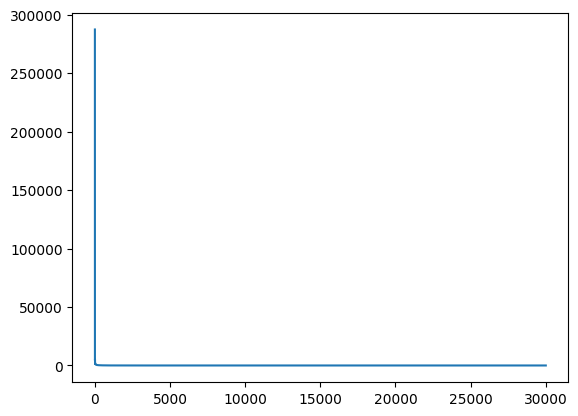

In [7]:
# gradient descent
L = 1000
f1 = gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y_0=x0` e $t_0=1$:
\begin{align*}
X_{k+1}&:= Y_k - la\nabla f(Y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
Y_{k+1} &:= X_{k+1} + \frac{t_{k}-1}{t_{k+1}}(X_{k+1}-X_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $Y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com passo `la=1./L` com `L=30000`.

In [8]:
#Escreva código aqui
def accel_gd(J, df, x0, la = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    grad_norm_history = []

    # Inicializando X_0 como uma cópia do x0
    x = x0.copy()
    # Inicializando Y_k e t_0
    y = x
    t0 = 1

    # Calculando o gradiente
    grad = df(y)
    # Salvando o erro
    grad_norm_history.append(J(grad))

    # Em cada iteração...
    for _ in range(numb_iter):
        # Atualiza o X_(k+1)
        x1 = y - la * grad
        # Atualiza o t_(k+1)
        t1 = (1 + np.sqrt(1 + 4 * t0 ** 2))/2
        # Atualiza o Y_k
        y = x1 + ((t0 - 1)/t1) * (x1 - x)

        # Calcula o gradiente
        grad = df(y)
        # Salva o erro
        grad_norm_history.append(J(grad))

        # Avança o X_k e o t_k
        x = x1
        t0 = t1

    return grad_norm_history, y

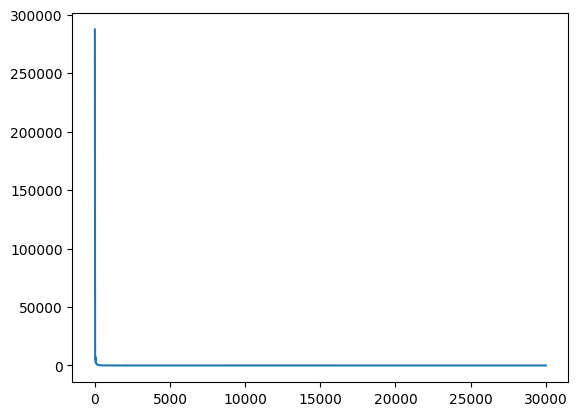

In [9]:
# Nesterov accelerated gradient descent
L = 30000
f2 = accel_gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f2[0])

# Exercício 4: Adagrad-Norm

Construa uma função `ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `x0`:
\begin{align*}
X_{k+1}&:= X_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(X_j)\Vert_2^2}} \nabla f(X_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com `b0=0.5` e `eta=1`.

In [10]:
#Escreva código aqui
def ad_grad_norm(J, df, x0, b0 = 0.5, eta = 1, numb_iter = 100):
    # Inicializando o histórico de erros
    grad_norm_history = []
    # Inicializando a soma dos quadrados das normas dos gradientes
    grads_sum = 0

    # Criando uma cópia do x0
    x = x0.copy()

    # Calculando o gradiente e sua norma
    grad = df(x)
    grad_norm = J(grad)
    # Salvando o erro
    grad_norm_history.append(grad_norm)
    # Incrementando a soma das normas dos gradientes
    grads_sum += grad_norm**2

    for _ in range(numb_iter):
        x -= (eta/(np.sqrt(b0**2 + grads_sum))) * grad

        # Calcula o gradiente
        grad = df(x)
        # Salva o erro
        grad_norm_history.append(J(grad))
        # Incrementa a soma das normas dos gradientes
        grads_sum += grad**2

    return grad_norm_history, x

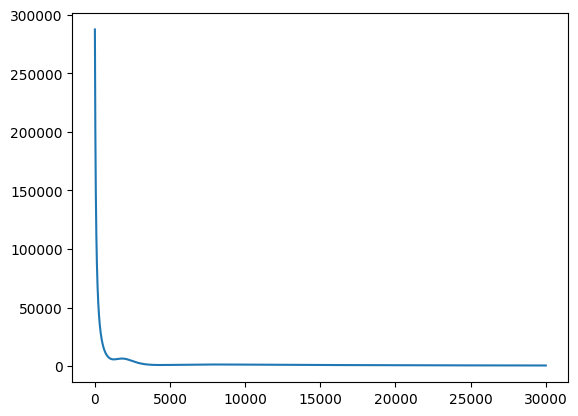

In [11]:
# Adagrad-Norm
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
plt.plot(f3[0])

# Exercício 5: Adam

Construa uma função `adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `x0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(X_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(X_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
X_{k+1}[j] &:= X_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon}\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`.

In [12]:
#Escreva código aqui
def adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter):
    # Inicializando o histórico de erros
    grad_norm_history = []

    # Criando uma cópia do x0
    x = x0.copy()
    # Inicializando as variáveis
    m = 0
    v = 0

    # Calculando o gradiente e sua norma
    grad = df(x)
    # Salvando o erro
    grad_norm_history.append(J(grad))

    # Em cada iteração...
    for k in range(numb_iter):
        # Atualiza as variáveis
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = (1/(1 - beta1**(k + 1))) * m
        v_hat = (1/(1 - beta2**(k + 1))) * v
        x -= (alpha/(np.sqrt(v_hat) + epsilon)) * m_hat

        # Calcula o gradiente e sua norma
        grad = df(x)
        # Salva o erro
        grad_norm_history.append(J(grad))

    return grad_norm_history, x

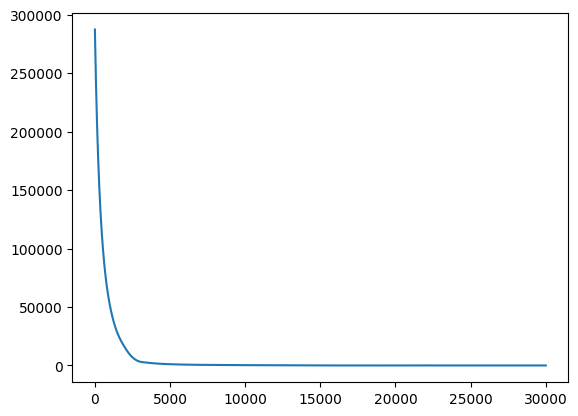

In [13]:
# Adam
f4 = adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
plt.plot(f4[0])

# Exercício 6:

Implemente num mesmo gráfico os erros $\Vert\nabla f(X_k)\Vert$ de cada método em função no número de iterações.

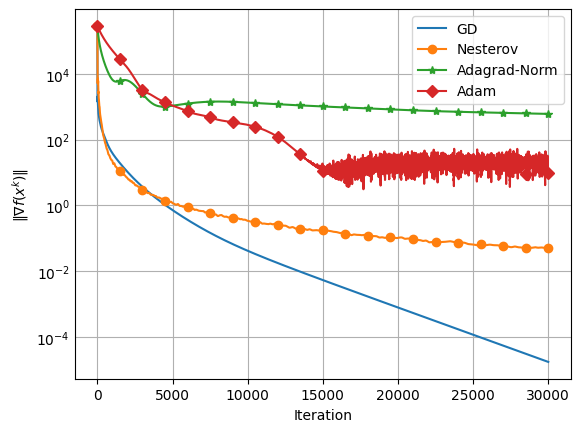

In [14]:
#Escreva código aqui
def plot_errors(f1, f2, f3, f4):
    # Plotando as linhas
    plt.plot(f1[0], label = "GD")
    plt.plot(f2[0], label = "Nesterov", marker = "o", markevery = 1500)
    plt.plot(f3[0], label = "Adagrad-Norm", marker = "*", markevery = 1500)
    plt.plot(f4[0], label = "Adam", marker = "D", markevery = 1500)
    # Ajustando os eixos
    plt.xlabel("Iteration")
    plt.yscale("log")
    plt.ylabel(r"$\|\nabla f(x^k)\|$")
    plt.tick_params(axis = "y", which = "both", length = 0)
    # Ativando a legenda e o grid
    plt.legend()
    plt.grid(True)

plot_errors(f1, f2, f3, f4)

# Exercício 7:

Experimente com os hyper-parâmetros de Adagrad-Norm e Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 6.

In [15]:
# TESTANDO HIPERPARÂMETROS DO ADAGRAD-NORM

# Inicializando variáveis para armazenar os melhores resultados
best_b0 = 0
best_eta = 0
best_error = np.infty

# Valores a serem testados
b0s = [0.1, 0.5, 1]
etas = [0.01, 0.1, 1]

# Para cada valor candidato de b0...
for b0 in b0s:
    # Para cada valor candidado de eta...
    for eta in etas:
        # Calcula o erro final do modelo
        final_error = ad_grad_norm(J, df, X0, b0, eta, 3000)[0][-1]
        # Se for menor que o melhor erro até agora...
        if final_error < best_error:
            # Salva essa configuração como a melhor até agora
            best_error = final_error
            best_b0 = b0
            best_eta = eta

print("Best b0: ", best_b0)
print("Best eta: ", best_eta)

Best b0:  0.1
Best eta:  1


In [16]:
# Rodando o modelo com os melhores parâmetros encontrados
g3 = ad_grad_norm(J, df, X0, best_b0, best_eta, N)

In [17]:
# TESTANDO HIPERPARÂMETROS DO ADAM

# Inicializando variáveis para armazenar os melhores resultados
best_alpha = 0
best_beta1 = 0
best_beta2 = 0
best_epsilon = 0
best_error = np.infty

# Valores a serem testados
alphas = [0.0005, 0.001]
beta1s = [0.85, 0.9]
beta2s = [0.995, 0.999]
epsilons = [10**(-8), 10**(-6)]

# Para cada valor candidato de alpha...
for alpha in alphas:
    # Para cada valor candidado de b1...
    for beta1 in beta1s:
        # # Para cada valor candidato de b2...
        for beta2 in beta2s:
            # Para cada valor candidato de epsilon...
            for epsilon in epsilons:
                # Calcula o erro final do modelo
                final_error = adam(J, df, X0, alpha, beta1, beta2, epsilon, 3000)[0][-1]
                # Se for menor que o melhor erro até agora...
                if final_error < best_error:
                    # Salva essa configuração como a melhor até agora
                    best_error = final_error
                    best_alpha = alpha
                    best_beta1 = beta1
                    best_beta2 = beta2
                    best_epsilon = epsilon

print("Best alpha: ", best_alpha)
print("Best beta1: ", best_beta1)
print("Best beta2: ", best_beta2)
print("Best epsilon: ", best_epsilon)

Best alpha:  0.001
Best beta1:  0.9
Best beta2:  0.995
Best epsilon:  1e-06


In [18]:
# Rodando o modelo com os melhores parâmetros encontrados
g4 = adam(J, df, X0, best_alpha, best_beta1, best_beta2, best_epsilon, N)

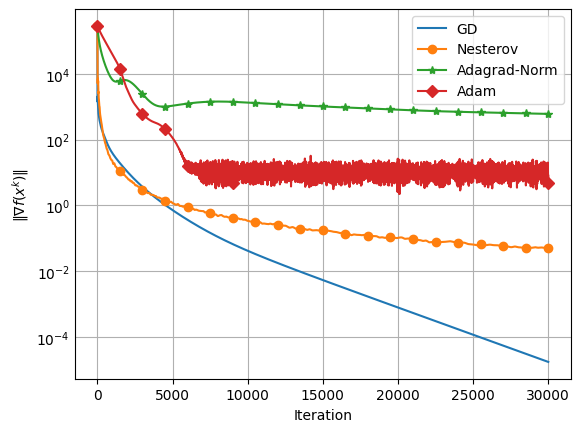

In [19]:
# Plotando os erros dos modelos com melhores hiperparâmetros
plot_errors(f1, f2, g3, g4)